In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import PIL
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms, datasets
import torch.nn as nn

/home/vydat/miniconda3/envs/ai_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vydat/miniconda3/envs/ai_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import os

data_path = '/home/vydat/Code/ML_AI/Lemon_Classification/lemon_dataset'

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp')

for root, dirs, files in os.walk(data_path):
    for file in files:
        if not file.lower().endswith(valid_exts):
            file_path = os.path.join(root, file)
            print(f'Xóa file không hợp lệ: {file_path}')
            os.remove(file_path)


In [3]:
data_path = '/home/vydat/Code/ML_AI/Lemon_Classification/lemon_dataset'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_loader = datasets.ImageFolder(
    root=data_path,
    transform=transform
)

data_size = len(data_loader)
test_size = int(0.2 * data_size)
train_size = int(0.7 * data_size)
val_size = data_size - test_size - train_size

train_data, test_data, vale_data = random_split(data_loader, ([train_size, test_size, val_size]))

train_loader = DataLoader(train_data,batch_size=64,  shuffle= True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
val_loader = DataLoader(vale_data, batch_size=63, shuffle=False)

print(f'{data_size}, {train_size}, {val_size}, {test_size}')

2076, 1453, 208, 415


In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16), 
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

In [6]:
def train(train_loader, val_loader, model, criterion, optimizer, device, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for ep in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for _, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
        print(f"Epoch {ep+1}/{epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} - ")
        
    example_input = torch.randn(1, 3, 128, 128).to(device) 
    traced_model = torch.jit.trace(model, example_input)
    traced_model.save('/home/vydat/Code/ML_AI/Lemon_Classification/model.pt')
    return model, train_loss, train_acc, val_loss, val_acc, ep+1

In [7]:
ep = 20
model, train_loss, train_acc, val_loss, val_acc, ep = train(train_loader, val_loader, model, criterion, optimizer, device, ep)

Epoch 1/20 - Train Loss: 0.3249, Train Acc: 0.8837 - Val Loss: 1.2889, Val Acc: 0.5529 - 
Epoch 2/20 - Train Loss: 0.1062, Train Acc: 0.9704 - Val Loss: 0.6523, Val Acc: 0.7644 - 
Epoch 3/20 - Train Loss: 0.0574, Train Acc: 0.9855 - Val Loss: 0.1888, Val Acc: 0.9279 - 
Epoch 4/20 - Train Loss: 0.0672, Train Acc: 0.9766 - Val Loss: 0.0635, Val Acc: 0.9856 - 
Epoch 5/20 - Train Loss: 0.0502, Train Acc: 0.9862 - Val Loss: 0.3483, Val Acc: 0.8942 - 
Epoch 6/20 - Train Loss: 0.0415, Train Acc: 0.9862 - Val Loss: 0.1176, Val Acc: 0.9519 - 
Epoch 7/20 - Train Loss: 0.0352, Train Acc: 0.9876 - Val Loss: 0.1342, Val Acc: 0.9712 - 
Epoch 8/20 - Train Loss: 0.0495, Train Acc: 0.9807 - Val Loss: 0.1089, Val Acc: 0.9712 - 
Epoch 9/20 - Train Loss: 0.0325, Train Acc: 0.9911 - Val Loss: 0.4551, Val Acc: 0.8269 - 
Epoch 10/20 - Train Loss: 0.0391, Train Acc: 0.9904 - Val Loss: 0.3526, Val Acc: 0.9135 - 
Epoch 11/20 - Train Loss: 0.0775, Train Acc: 0.9690 - Val Loss: 0.1907, Val Acc: 0.9423 - 
Epoch 12

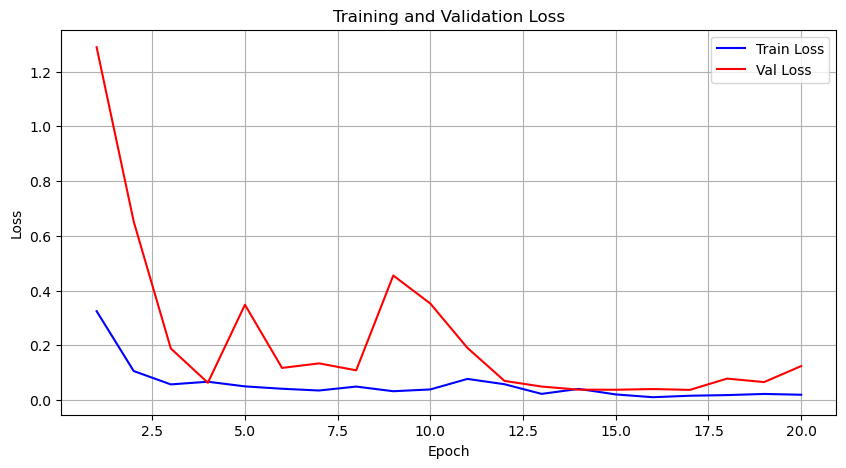

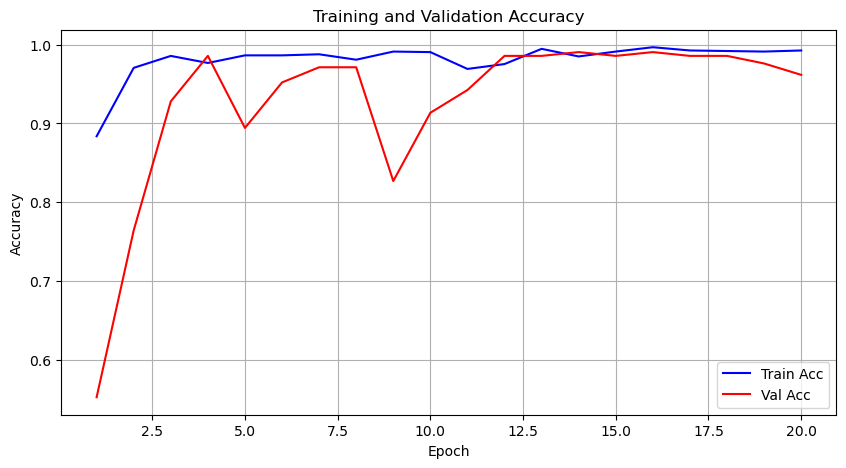

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, ep+1), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, ep+1), val_loss, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, ep+1), train_acc, label='Train Acc', color='blue')
plt.plot(range(1, ep+1), val_acc, label='Val Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
model = torch.load('/home/vydat/Code/ML_AI/Lemon_Classification/model.pt')
model.eval()
test_running_loss = 0.0
correct = 0
total = 0
wrong_images = []
wrong_preds = []
wrong_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        for i in range(len(images)):
            if predicted[i] != labels[i]:
                wrong_images.append(images[i])
                wrong_preds.append(predicted[i].item())
                wrong_labels.append(labels[i].item())

test_loss = test_running_loss / len(test_loader)
test_acc = correct / total

print(f'{test_loss:.4f}')
print(f'{test_acc:.4f}')

/tmp/ipykernel_17192/1115331682.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/vydat/Code/ML_AI/Lemon_Classification/model.pt')
/home/vydat/mi

0.0404
0.9880


5


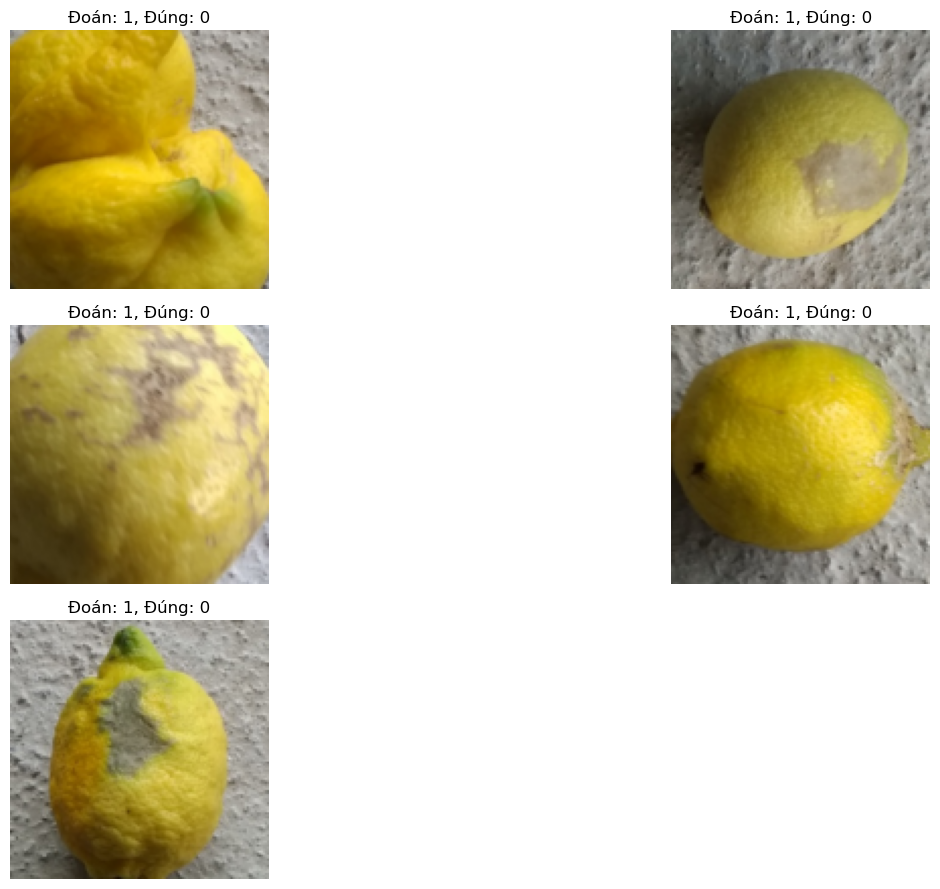

In [10]:
import matplotlib.pyplot as plt

print(len(wrong_images))
num_images = len(wrong_images)
rows = 3
cols = (num_images + rows - 1) // rows

plt.figure(figsize=(15, 9))

for i in range(num_images):
    image = wrong_images[i].cpu()
    image = image.permute(1, 2, 0)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.title(f"Đoán: {wrong_preds[i]}, Đúng: {wrong_labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()